In [6]:
"""
Carbon Footprint Model Training
Author: Onkar Kapuskari
Date: 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
import os
import sklearn

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"   NumPy version: {np.__version__}")
print(f"   Pandas version: {pd.__version__}")
print(f"   Scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
   NumPy version: 1.26.2
   Pandas version: 2.1.3
   Scikit-learn version: 1.3.2


In [7]:
print("="*80)
print("LOADING DATASET")
print("="*80)

# Load dataset
df = pd.read_csv('../data/raw/carbon_dataset.csv')

print(f"✅ Dataset loaded successfully!")
print(f"   Shape: {df.shape}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display head and info
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset Info:")
df.info()

LOADING DATASET
✅ Dataset loaded successfully!
   Shape: (10000, 20)
   Memory Usage: 7.67 MB

First 5 rows:


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null 

In [8]:
def preprocess_data(data):
    """
    Preprocesses the dataset for model training.
    Handles encoding, missing values, and separation of features/target.
    """
    df = data.copy()
    
    # Handle missing Vehicle Type (fill with 'None' or 'No Vehicle')
    if 'Vehicle Type' in df.columns:
        df['Vehicle Type'] = df['Vehicle Type'].fillna('No Vehicle')
        print("Filled missing 'Vehicle Type' with 'No Vehicle'.")

    # Identify target column
    target_col = 'CarbonEmission'
    if target_col not in df.columns:
        raise ValueError("Target variable 'CarbonEmission' not found!")
    
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    
    print(f"✅ Target column: {target_col}")
    print(f"Features: {X.shape[1]} | Samples: {len(X)}")

    # Ordinal encoding for specific ordered columns
    ordinal_mappings = {
        'Body Type': {'underweight': 0, 'normal': 1, 'overweight': 2, 'obese': 3},
        'Sex': {'female': 0, 'male': 1},
        'How Often Shower': {'less frequently': 0, 'daily': 1, 'twice a day': 2, 'more frequently': 3},
        'Social Activity': {'never': 0, 'sometimes': 1, 'often': 2},
        'Frequency of Traveling by Air': {'never': 0, 'rarely': 1, 'frequently': 2, 'very frequently': 3},
        'Waste Bag Size': {'small': 0, 'medium': 1, 'large': 2, 'extra large': 3},
        'Energy efficiency': {'No': 0, 'Sometimes': 1, 'Yes': 2}
    }

    for col, mapping in ordinal_mappings.items():
        if col in X.columns:
            X[col] = X[col].map(mapping)
            print(f"✓ Encoded ordinal column: {col}")

    # One-hot encode nominal categorical variables
    nominal_cols = ['Diet', 'Heating Energy Source', 'Transport', 'Vehicle Type', 
                    'Recycling', 'Cooking_With']
    nominal_cols = [col for col in nominal_cols if col in X.columns]

    X = pd.get_dummies(X, columns=nominal_cols, drop_first=False, dtype=int)
    print(f"✓ One-hot encoded {len(nominal_cols)} nominal columns")
    
    # Check for remaining categorical columns
    remaining_cat = X.select_dtypes(include=['object']).columns
    if len(remaining_cat) > 0:
        print(f"⚠️ Remaining categorical columns found: {remaining_cat.tolist()}")
        for col in remaining_cat:
            X[col] = pd.Categorical(X[col]).codes
            print(f"✓ Label encoded: {col}")
    
    print("\n✅ Preprocessing complete!")
    print(f"Final features: {X.shape[1]} | All numeric: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")

    return X, y


# Run preprocessing
X, y = preprocess_data(df)

print("\nSample of encoded features:")
display(X.head())

Filled missing 'Vehicle Type' with 'No Vehicle'.
✅ Target column: CarbonEmission
Features: 19 | Samples: 10000
✓ Encoded ordinal column: Body Type
✓ Encoded ordinal column: Sex
✓ Encoded ordinal column: How Often Shower
✓ Encoded ordinal column: Social Activity
✓ Encoded ordinal column: Frequency of Traveling by Air
✓ Encoded ordinal column: Waste Bag Size
✓ Encoded ordinal column: Energy efficiency
✓ One-hot encoded 6 nominal columns

✅ Preprocessing complete!
Final features: 62 | All numeric: True

Sample of encoded features:


,Body Type,Sex,How Often Shower,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
0,2,0,1,2,230,2,210,2,4,7,...,0,0,0,0,0,0,0,1,0,0
1,3,0,0,2,114,1,9,3,3,9,...,0,0,0,1,0,0,0,0,0,0
2,2,1,3,0,138,0,2472,0,1,14,...,0,0,0,0,0,0,0,0,0,0
3,2,1,2,1,157,1,74,1,3,20,...,0,0,0,0,0,0,0,0,0,0
4,3,0,1,2,266,3,8457,2,1,3,...,1,0,0,0,0,0,0,0,0,0


In [9]:
print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

# Log-transform target for better distribution
y_log = np.log(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"✅ Train-Test Split Complete")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

TRAIN-TEST SPLIT
✅ Train-Test Split Complete
Training Samples: 8000
Test Samples: 2000
Features: 62


In [12]:
print("="*80)
print("FEATURE STATISTICS BEFORE SCALING")
print("="*80)

print("Mean (train):", X_train.mean(axis=0).mean())
print("Std (train):", X_train.std(axis=0).mean())


FEATURE STATISTICS BEFORE SCALING
Mean (train): 36.66264112903225
Std (train): 46.68009987531814


In [10]:
print("="*80)
print("FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling complete!")
print(f"Mean (train): {X_train_scaled.mean():.5f}")
print(f"Std (train): {X_train_scaled.std():.5f}")

FEATURE SCALING
✅ Scaling complete!
Mean (train): 0.00000
Std (train): 1.00000


In [11]:

print("="*80)
print("TRAINING MLP REGRESSOR MODEL")
print("="*80)

model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50,
    verbose=True
)

model.fit(X_train_scaled, y_train)

print(f"\n✅ Training complete in {model.n_iter_} iterations!")
print(f"Final loss: {model.loss_:.6f}")


TRAINING MLP REGRESSOR MODEL
Iteration 1, loss = 13.54858640
Validation score: -13.254383
Iteration 2, loss = 0.60919829
Validation score: -1.330564
Iteration 3, loss = 0.20868078
Validation score: -0.878009
Iteration 4, loss = 0.17438850
Validation score: -0.624142
Iteration 5, loss = 0.15005079
Validation score: -0.448785
Iteration 6, loss = 0.12929204
Validation score: -0.269974
Iteration 7, loss = 0.11204526
Validation score: -0.126264
Iteration 8, loss = 0.09774005
Validation score: -0.023396
Iteration 9, loss = 0.08583502
Validation score: 0.080711
Iteration 10, loss = 0.07608430
Validation score: 0.143112
Iteration 11, loss = 0.06759027
Validation score: 0.224131
Iteration 12, loss = 0.06071711
Validation score: 0.282887
Iteration 13, loss = 0.05435071
Validation score: 0.330828
Iteration 14, loss = 0.04938742
Validation score: 0.376254
Iteration 15, loss = 0.04499468
Validation score: 0.418862
Iteration 16, loss = 0.04108502
Validation score: 0.438847
Iteration 17, loss = 0.037

In [13]:
# ================================================================
# Cell 7: Evaluate Model
# ================================================================
print("="*80)
print("MODEL EVALUATION")
print("="*80)

# Predictions (log)
y_train_pred_log = model.predict(X_train_scaled)
y_test_pred_log = model.predict(X_test_scaled)

# Convert back to normal scale
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)
y_train_actual = np.exp(y_train)
y_test_actual = np.exp(y_test)

# Metrics
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

print(f"{'Metric':<20}{'Train':>15}{'Test':>15}")
print("-"*50)
print(f"{'R² Score':<20}{train_r2:>15.4f}{test_r2:>15.4f}")
print(f"{'RMSE (kg CO₂)':<20}{train_rmse:>15.2f}{test_rmse:>15.2f}")
print(f"{'MAE (kg CO₂)':<20}{train_mae:>15.2f}{test_mae:>15.2f}")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"\nCross-validation R²: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")


MODEL EVALUATION
Metric                        Train           Test
--------------------------------------------------
R² Score                     0.9854         0.8689
RMSE (kg CO₂)                122.84         369.22
MAE (kg CO₂)                  51.62         251.47
Iteration 1, loss = 16.70000878
Validation score: -11.197171
Iteration 2, loss = 0.88504665
Validation score: -2.939074
Iteration 3, loss = 0.26831842
Validation score: -1.121903
Iteration 4, loss = 0.19718089
Validation score: -0.892904
Iteration 5, loss = 0.17194810
Validation score: -0.701135
Iteration 6, loss = 0.15231249
Validation score: -0.547352
Iteration 7, loss = 0.13474229
Validation score: -0.404819
Iteration 8, loss = 0.11896636
Validation score: -0.290354
Iteration 9, loss = 0.10655552
Validation score: -0.193868
Iteration 10, loss = 0.09498660
Validation score: -0.092280
Iteration 11, loss = 0.08512101
Validation score: -0.015487
Iteration 12, loss = 0.07705470
Validation score: 0.049392
Iteration 13, lo

CREATING VISUALIZATIONS


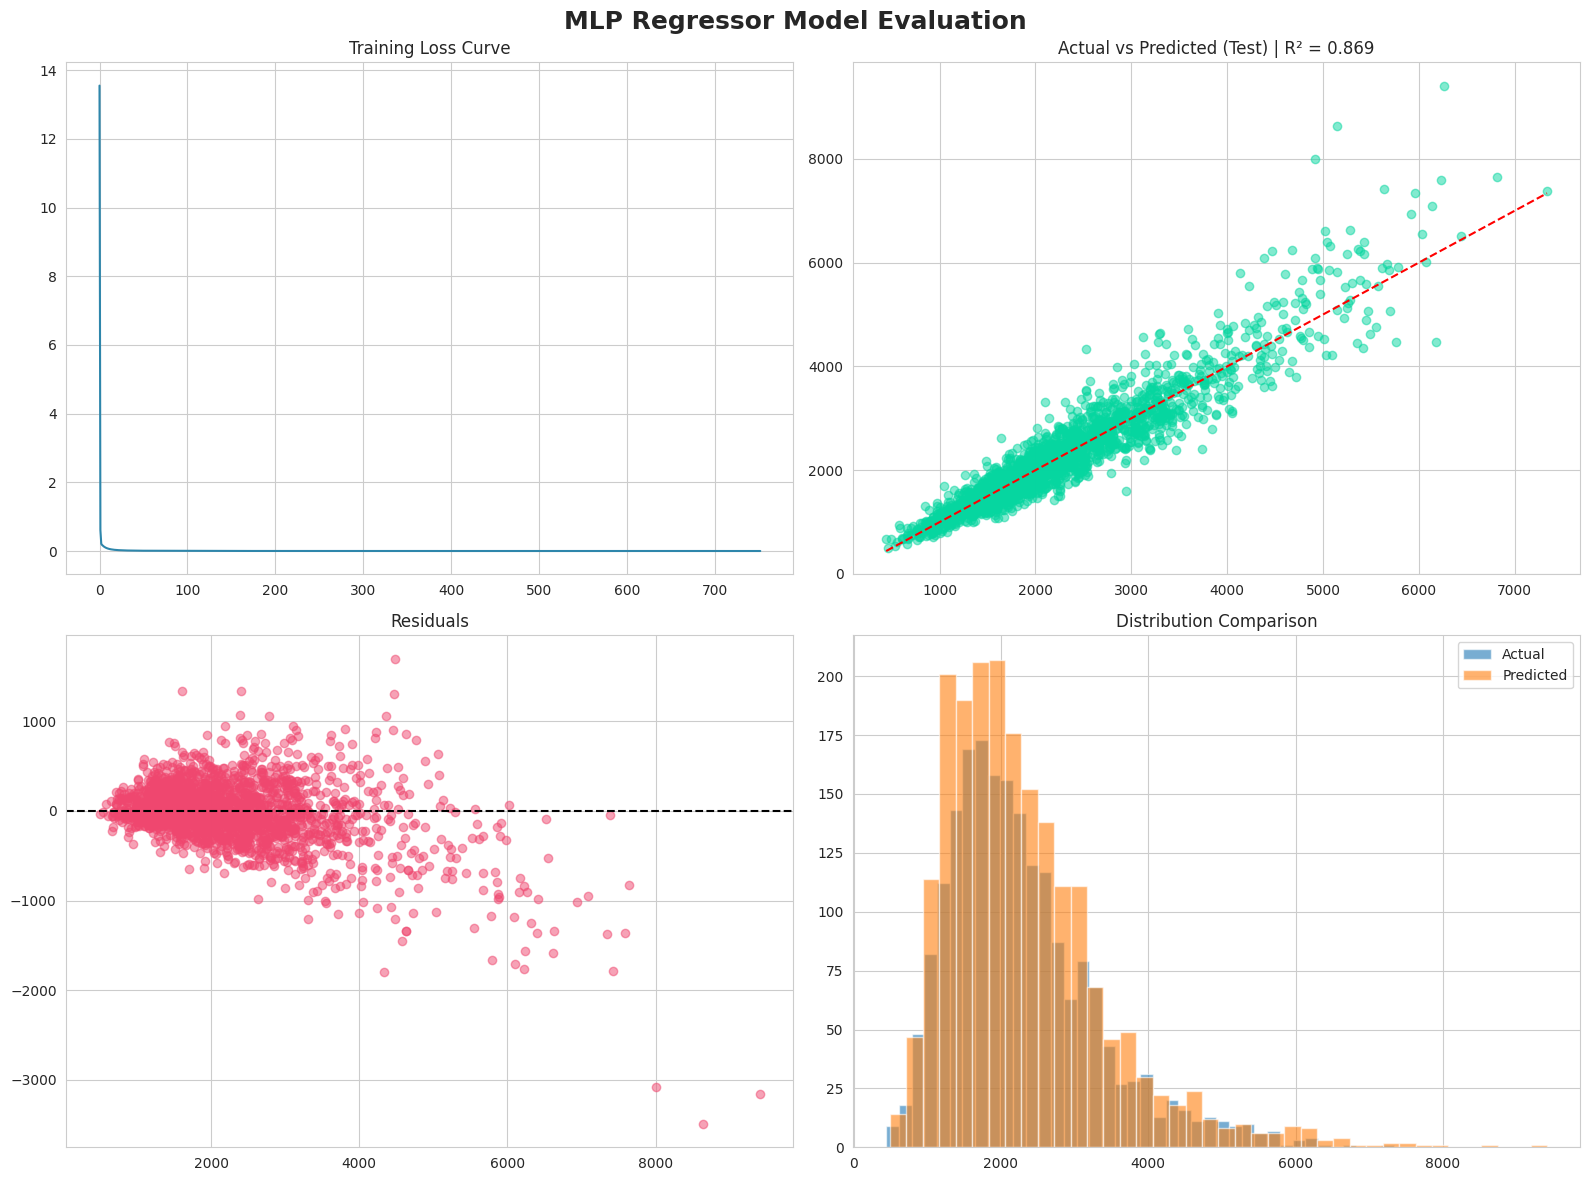

✅ Visualizations saved to ../data/processed/model_evaluation.png


In [14]:
# ================================================================
# Cell 8: Visualizations
# ================================================================
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MLP Regressor Model Evaluation', fontsize=18, fontweight='bold')

# Loss curve
axes[0, 0].plot(model.loss_curve_, color='#2E86AB')
axes[0, 0].set_title('Training Loss Curve')

# Actual vs Predicted
axes[0, 1].scatter(y_test_actual, y_test_pred, color='#06D6A0', alpha=0.5)
axes[0, 1].plot([y_test_actual.min(), y_test_actual.max()],
                [y_test_actual.min(), y_test_actual.max()], 'r--')
axes[0, 1].set_title(f'Actual vs Predicted (Test) | R² = {test_r2:.3f}')

# Residuals
res = y_test_actual - y_test_pred
axes[1, 0].scatter(y_test_pred, res, color='#EF476F', alpha=0.5)
axes[1, 0].axhline(y=0, color='black', linestyle='--')
axes[1, 0].set_title('Residuals')

# Distribution comparison
axes[1, 1].hist(y_test_actual, bins=40, alpha=0.6, label='Actual')
axes[1, 1].hist(y_test_pred, bins=40, alpha=0.6, label='Predicted')
axes[1, 1].legend()
axes[1, 1].set_title('Distribution Comparison')

plt.tight_layout()
plt.savefig('../data/processed/model_evaluation.png', dpi=300)
plt.show()

print("✅ Visualizations saved to ../data/processed/model_evaluation.png")


In [15]:
# ================================================================
# Cell 9: Save Model
# ================================================================
print("="*80)
print("SAVING MODEL ARTIFACTS")
print("="*80)

os.makedirs('../models', exist_ok=True)

joblib.dump(model, '../models/model.sav')
joblib.dump(scaler, '../models/scale.sav')

with open('../models/feature_names.txt', 'w') as f:
    f.write("\n".join(X.columns))

print("✅ Model and scaler saved successfully!")


SAVING MODEL ARTIFACTS
✅ Model and scaler saved successfully!


In [16]:
# ================================================================
# Cell 10: Test Prediction
# ================================================================
print("="*80)
print("TESTING MODEL WITH SAMPLE DATA")
print("="*80)

sample = X_test.iloc[0:1]
scaled_sample = scaler.transform(sample)
pred_log = model.predict(scaled_sample)
pred = np.exp(pred_log)[0]

print("Sample features:")
display(sample)
print(f"\n🔮 Predicted Carbon Emission: {pred:.2f} kg CO₂")


TESTING MODEL WITH SAMPLE DATA
Sample features:


,Body Type,Sex,How Often Shower,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
6252,1,0,2,2,193,1,569,0,6,18,...,0,0,0,0,0,0,0,0,0,0



🔮 Predicted Carbon Emission: 994.22 kg CO₂


Exception ignored in: <function ResourceTracker.__del__ at 0x7f9607402660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f34109fa660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f619d356660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multip


Validation score: 0.865235
Iteration 414, loss = 0.00062774
Validation score: 0.862326
Iteration 415, loss = 0.00098980
Validation score: 0.858574
Iteration 416, loss = 0.00108790
Validation score: 0.856103
Iteration 417, loss = 0.00092051
Validation score: 0.862541
Iteration 418, loss = 0.00062318
Validation score: 0.860573
Iteration 419, loss = 0.00057102
Validation score: 0.859271
Iteration 420, loss = 0.00066538
Validation score: 0.859102
Iteration 421, loss = 0.00060400
Validation score: 0.862312
Iteration 422, loss = 0.00045209
Validation score: 0.864255
Iteration 423, loss = 0.00035670
Validation score: 0.862785
Iteration 424, loss = 0.00029399
Validation score: 0.865905
Iteration 425, loss = 0.00027150
Validation score: 0.865836
Iteration 426, loss = 0.00034727
Validation score: 0.861394
Iteration 427, loss = 0.00029471
Validation score: 0.864780
Iteration 428, loss = 0.00026346
Validation score: 0.863967
Iteration 429, loss = 0.00020911
Validation score: 0.866880
Iteration 43

Exception ignored in: <function ResourceTracker.__del__ at 0x7f1884bbe660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Validation score: 0.886183
Iteration 825, loss = 0.00020787
Validation score: 0.883115
Iteration 826, loss = 0.00020201
Validation score: 0.886063
Iteration 827, loss = 0.00015025
Validation score: 0.886222
Iteration 828, loss = 0.00013949
Validation score: 0.886813
Iteration 829, loss = 0.00011791
Validation score: 0.885381
Iteration 830, loss = 0.00010656
Validation score: 0.886540
Iteration 831, loss = 0.00010832
Validation score: 0.886560
Iteration 832, loss = 0.00011998
Validation score: 0.887109
Iteration 833, loss = 0.00012260
Validation score: 0.883881
Iteration 834, loss = 0.00017316
Validation score: 0.886069
Iteration 835, loss = 0.00016268
Validation score: 0.886098
Iteration 836, loss = 0.00013667
Validation score: 0.885843
Iteration 837, loss = 0.00016717
Validation score: 0.887032
Iteration 838, loss = 0.00012702
Validation score: 0.885855
Iteration 839, loss = 0.00015427
Validation score: 0.885425
Iteration 840, loss = 0.00036397
Validation score: 0.883500
Iteration 84

Exception ignored in: <function ResourceTracker.__del__ at 0x7f80c4d72660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Validation score: 0.847741
Iteration 962, loss = 0.00012727
Validation score: 0.846012
Iteration 963, loss = 0.00014324
Validation score: 0.844301
Iteration 964, loss = 0.00014428
Validation score: 0.844380
Iteration 965, loss = 0.00014361
Validation score: 0.844698
Iteration 966, loss = 0.00013987
Validation score: 0.846551
Iteration 967, loss = 0.00011260
Validation score: 0.846392
Iteration 968, loss = 0.00010565
Validation score: 0.847246
Iteration 969, loss = 0.00010921
Validation score: 0.844786
Iteration 970, loss = 0.00012473
Validation score: 0.845605
Iteration 971, loss = 0.00025438
Validation score: 0.843655
Iteration 972, loss = 0.00037845
Validation score: 0.842158
Iteration 973, loss = 0.00039763
Validation score: 0.845649
Iteration 974, loss = 0.00036444
Validation score: 0.844362
Iteration 975, loss = 0.00036346
Validation score: 0.845488
Iteration 976, loss = 0.00069653
Validation score: 0.840586
Iteration 977, loss = 0.00086472
Validation score: 0.836769
Iteration 97

Exception ignored in: <function ResourceTracker.__del__ at 0x7fa930fbe660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Validation score: 0.866191
Iteration 962, loss = 0.00103002
Validation score: 0.865980
Iteration 963, loss = 0.00107838
Validation score: 0.867694
Iteration 964, loss = 0.00066695
Validation score: 0.873194
Iteration 965, loss = 0.00082914
Validation score: 0.869489
Iteration 966, loss = 0.00056581
Validation score: 0.876480
Iteration 967, loss = 0.00045779
Validation score: 0.875425
Iteration 968, loss = 0.00043293
Validation score: 0.870318
Iteration 969, loss = 0.00038395
Validation score: 0.873100
Iteration 970, loss = 0.00024792
Validation score: 0.875136
Iteration 971, loss = 0.00021617
Validation score: 0.875282
Iteration 972, loss = 0.00015833
Validation score: 0.876499
Iteration 973, loss = 0.00014619
Validation score: 0.873680
Iteration 974, loss = 0.00014399
Validation score: 0.876156
Iteration 975, loss = 0.00012962
Validation score: 0.875556
Iteration 976, loss = 0.00011718
Validation score: 0.875342
Iteration 977, loss = 0.00012047
Validation score: 0.875997
Iteration 97

Exception ignored in: <function ResourceTracker.__del__ at 0x7efd38e32660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Iteration 1231, loss = 0.00030821
Validation score: 0.876359
Iteration 1232, loss = 0.00032766
Validation score: 0.875867
Iteration 1233, loss = 0.00034252
Validation score: 0.873987
Validation score did not improve more than tol=0.000100 for 50 consecutive epochs. Stopping.


Exception ignored in: <function ResourceTracker.__del__ at 0x7f8e21496660>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
